# Iteratoren und Generatoren in Python

Eine [Folge](https://de.wikipedia.org/wiki/Folge_(Mathematik)) ist in der Mathematik _eine Auflistung (Familie) von endlich oder unendlich vielen fortlaufend nummerierten Objekten (beispielsweise Zahlen)_. Nur, wie gehen wir praktisch in Python mit dieser Unendlichkeit um? Und könnte uns das Prinzip auch anderweitig weiterhelfen?

## Die Fibonacci-Folge

Wir möchten wiederverwendbaren Code schreiben, der die Fibonacci-Folge generiert.

Unser erster Versuch ist eine Funktion, die die ersten `n` Elemente der Fibonacci-Folge generiert und in einer Liste zurückgibt:

In [23]:
def fibonacci(limit=10):
    result = []
    one = 0
    two = 1
    for i in range(limit):
        one, two = two, one + two
        result.append(one)
    return result

print(fibonacci(10))

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55]


Das Problem ist nur, dass die Liste viel Speicher frisst, wenn wir eine grosse Anzahl Elemente benötigen. Beispiel: wir möchten die Summe der ersten `n` Fibonacci-Zahlen berechnen, ohne den Speicherplatz für die Liste aufzuwenden. Oder wir wissen gar nicht im Voraus, wieviele Elemente nötig sind, wenn wir zum Beispiel die erste Fibonacci-Zahl grösser als 1000 suchen.

Natürlich könnten wir für beide Probleme eine eigene, effiziente Funktion schreiben, die ohne Liste auskommt - aber als faule Informatiker möchten wir es vermeiden, den gleichen Code zweimal zu schreiben...

Gesucht ist also ein Stück Code, das einen _Strom_ von Fibonacci-Zahlen liefert, die wir kontinuierlich konsumieren können, bis wir genug haben.

## Iteratoren

Soche Objekte heissten _Iteratoren_. Ein Iterator hat nur eine einzige Funktion, `__next__`, die jeweils das nächste Element zurückgibt. Der Iterator muss sich irgendwie den Zustand merken, also wo in der Fibonacci-Folge er gerade steckt. Die Funktion wirft eine `StopIteration` Exception wenn es keine weiteren Elemente gibt.

Die built-in function [`next`](https://docs.python.org/3/library/functions.html#next) kann verwendet werden, um aus einem Iterator das nächste Element zu holen.

In [34]:
class FiboIterator:
    def __init__(self, limit = -1):
        # Hier wird der Zustand gespeichert
        self.one = 0
        self.two = 1
        self.limit = limit
    
    def __next__(self):
        if self.limit == 0:
            raise StopIteration()
        self.one, self.two = self.two, self.one + self.two
        self.limit -= 1
        return self.one

iterator = FiboIterator()
res = 0
count = 0
while res < 1000:
    res = next(iterator)  # Die eingebaute Funktion next ruft __next__ auf.
    count += 1
print(f'Erste Fibonacci-Zahl grösser als 1000 ist {res} (#{count})')


Erste Fibonacci-Zahl grösser als 1000 ist 1597 (#17)


# Iterables

Möchten wir unseren Iterator in einer `for`-Schleife einsetzen, müssen wir zusätzlich das Iterable-Protokoll beachten: Iterables müssen eine `__iter__` Funktion haben, die einen neuen, von vorne beginnenden Iterator zurückgibt. Wieso benötigen wir sowohl Iterable als auch Iterator? Stell dir vor, eine Liste möchte das Iterable-Protokoll implementieren - es ist entscheidend, dass jede neue Schleife wieder von vorne beginnt:

```python
alphabet = 'abcdef'
for letter1 in alphabet:      # Erster Iterator über die Sequence alphabet
    for letter2 in alphabet:  # Zweiter, unabhängiger Iterator über die gleiche Sequence
        print(letter1 + letters)
```

Spickzettel:
  * `__iter__` wird einmal aufgerufen, wenn die `for`-Schleife startet.
  * `__next__` wird vor jedem Schleifendurchgang aufgerufen und das Resultat der Schleifenvariable zugewiesen.

Die Funktionen werden [hier beschrieben](https://docs.python.org/3/library/stdtypes.html#iterator-types).

In [37]:

class Fibo:
    # Wird einmal aufgerufen, wenn Python den die for-Schleife startet.
    def __iter__(self):
        return FiboIterator()
    
sequence = Fibo()
for num in sequence:
    if num > 1000:
        print(f'Erste Fibonacci-Zahl grösser als 1000 ist {num}')
        break


Erste Fibonacci-Zahl grösser als 1000 ist 1597


Falls die Werte berechnet werden, können `__iter__` und `__next__` auch von derselben Klasse implementiert werden.

## Yield

Das ganze leuchtet ein, aber ist ziemlich kompliziert. Mit einem Generator und `yield` wird alles viel kompakter. Sobald unsere Funktion `yield` verwendet, erzeugt Python automatisch einen _[Generator](https://en.wikipedia.org/wiki/Generator_(computer_programming))_, d.h. ein Objekt, das sowohl _Iterator_ als auch _Iterable_ ist und sich den ganzen Zustand der Funktion merkt, wenn ein Element mit `yield` zurückgegeben wird.

Ein Generator kann damit auch als Ausdruck nach `in` in einer `for ... in <expression>` stehen.

In [38]:
def fibo():
    one = 0
    two = 1
    while True:
        one, two = two, one + two
        yield one

for num in fibo():
    if num > 1000:
        print(f'Erste Fibonacci-Zahl grösser als 1000 ist {num}')
        break


Erste Fibonacci-Zahl grösser als 1000 ist 1597


### Iteration beenden

Sind keine Elemente mehr übrig, wird einfach nichts zurückgegeben bzw. ein normales `return`:

In [57]:
def fibo(limit=-1):
    one = 0
    two = 1
    while limit != 0:
        limit -= 1
        one, two = two, one + two
        yield one

for num in fibo(10):
    print(num)

n = 100
print(f'Summe der ersten {n} Fibonacci-Zahlen: {sum(fibo(n))}')


1
1
2
3
5
8
13
21
34
55
Summe der ersten 100 Fibonacci-Zahlen: 927372692193078999175


## Yield From

Manchmal möchten wir eine andere Iteration (bzw. einen anderen Generator) in die gerade laufende Iteration einbinden. Dazu dienen die Keywords `yield from`.

Beispiel: ein einfacher Binärbaum besteht aus Knoten (_en_: Nodes), die jeweils bis zu zwei Kinder haben können.

Um den Baum zu traversieren (d.h. alle Knoten zu besuchen), können wir zum Beispiel die [In-Order Traversierung](https://de.wikipedia.org/wiki/Bin%C3%A4rbaum#Traversierung) wählen: Zuerst wird der linke Teilbaum durchlaufen, anschliessend der Knoten selbst, zum Schluss der rechte Teilbaum.

Eine rekursive Umsetzung könnte wie folgt aussehen - beachte, wie `yield from` eingesetzt wird, um die rekursive Traversierung zu erreichen.


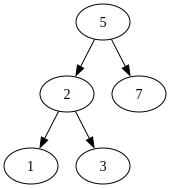

In [49]:
import graphviz

# Create Digraph object
dot = graphviz.Digraph()

# Add nodes
dot.node('1')
dot.node('2')
dot.node('3')
dot.node('5')
dot.node('7')

# Add edges
dot.edges(['52', '57', '21', '23'])

# Visualize the graph
dot

In [60]:
class Node:
    def __init__(self, key, left=None, right=None):
        self.key = key
        self.left = left
        self.right = right
    
    def in_order_traversal(self):
        if self.left:
            yield from self.left.in_order_traversal()
        yield self
        if self.right:
            yield from self.right.in_order_traversal()


tree = Node(5, Node(1), Node(7))

for node in tree.in_order_traversal(): print (node.key)

1
5
7


In [59]:
import itertools

for n in enumerate(fibo(10), 1): print(n)

(1, 1)
(2, 1)
(3, 2)
(4, 3)
(5, 5)
(6, 8)
(7, 13)
(8, 21)
(9, 34)
(10, 55)
